<a href="https://colab.research.google.com/github/yongbin02/P---AI/blob/main/K_means_12.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
# 모델 저장
import joblib
# 매핑 파일 저장
import json

### 0. 설정 (경로)

In [43]:
BASE_PATH = '/content/drive/MyDrive/Colab Notebooks/Project_P/' # 프로젝트 폴더 경로
TRAIN_FILE = BASE_PATH + 'data/감성대화말뭉치(최종데이터)_Training.xlsx'
VAL_FILE = BASE_PATH + 'data/감성대화말뭉치(최종데이터)_Validation.xlsx'
NUM_CLUSTERS = 12  # 결정된 군집 개수

### 1. 데이터 로드 및 전처리 함수 (Training/Validation 공용)

In [44]:
def load_and_preprocess(filepath):
    print(f"\n📂 파일 읽는 중... : {filepath}")

    try:
        # 엑셀 파일 읽기 (engine='openpyxl' 명시)
        df = pd.read_excel(filepath, engine='openpyxl')
    except Exception as e:
        print(f"❌ 파일 읽기 실패: {e}")
        return None

    # 필요한 컬럼만 선택 ('감정_대분류'는 나중에 검증용으로 사용)
    required_cols = ['사람문장1', '사람문장2', '사람문장3']

    # 가끔 빈 컬럼이 읽힐 때가 있음 -> 컬럼 존재 여부 확인
    target_cols = [col for col in required_cols if col in df.columns]

    if not target_cols:
        print(f"❌ 중요 컬럼({required_cols})이 없습니다. 엑셀 헤더를 확인해주세요.")
        return None

    # '사람문장1', '사람문장2', '사람문장3'을 세로로 합침 (Melt)
    df_melted = df.melt(
        id_vars=['감정_대분류'],
        value_vars=target_cols,
        value_name='text'
    )

    # 결측치(NaN) 및 공백 제거
    df_melted = df_melted.dropna(subset=['text'])
    df_melted = df_melted[df_melted['text'].str.strip() != ""]

    return df_melted

In [45]:
print("--- 1. 데이터 전처리 시작 ---")
train_df = load_and_preprocess(TRAIN_FILE)
val_df = load_and_preprocess(VAL_FILE)

if train_df is None:
    print("❌ 데이터를 읽을 수 없습니다.")
    exit()

print(f"✅ Training 데이터: {len(train_df)}개")
print(f"✅ Validation 데이터: {len(val_df)}개")
print(f" - 감정 종류: {train_df['감정_대분류'].unique()}")

--- 1. 데이터 전처리 시작 ---

📂 파일 읽는 중... : /content/drive/MyDrive/Colab Notebooks/Project_P/data/감성대화말뭉치(최종데이터)_Training.xlsx

📂 파일 읽는 중... : /content/drive/MyDrive/Colab Notebooks/Project_P/data/감성대화말뭉치(최종데이터)_Validation.xlsx
✅ Training 데이터: 145955개
✅ Validation 데이터: 17968개
 - 감정 종류: ['분노' '기쁨' '불안' '당황' '슬픔' '상처']


### 2. 텍스트 임베딩 (SBERT 사용)

In [46]:
print("\n--- 2. SBERT 임베딩 시작 (약 3~5분 소요) ---")
# 한국어 성능이 좋은 SBERT 모델 로드
model = SentenceTransformer('jhgan/ko-sbert-multitask')

# 텍스트를 벡터(숫자)로 변환
train_vectors = model.encode(train_df['text'].tolist(), show_progress_bar=True)


--- 2. SBERT 임베딩 시작 (약 3~5분 소요) ---


Batches:   0%|          | 0/4562 [00:00<?, ?it/s]

### 3. 비지도 학습 (K-Means Clustering)

In [47]:
print(f"\n--- 3. K-Means 군집화 시작 (Cluster 개수: {NUM_CLUSTERS}) ---")
kmeans = KMeans(n_clusters=NUM_CLUSTERS, random_state=42, n_init='auto')
kmeans.fit(train_vectors)

# Training 데이터에 군집 번호(label) 붙이기
train_df['cluster'] = kmeans.labels_


--- 3. K-Means 군집화 시작 (Cluster 개수: 12) ---


### 4. 결과 해석 (군집별 특징 확인 및 출력)

In [48]:
print("\n--- 4. 군집별 내용 분석 및 매핑 테이블 저장 ---")

cluster_analysis = []

for i in range(NUM_CLUSTERS):
    # 해당 군집에 속한 데이터 필터링
    cluster_data = train_df[train_df['cluster'] == i]

    if len(cluster_data) == 0:
        continue

    # 주된 감정 파악
    dominant_emotion = cluster_data['감정_대분류'].value_counts().idxmax()
    emotion_percent = (cluster_data['감정_대분류'].value_counts().max() / len(cluster_data)) * 100

    # 예시 문장 3개 뽑기
    # cluster_data의 크기가 3개 미만일 수 있으므로 min(3, len(cluster_data)) 사용
    num_samples = min(3, len(cluster_data))
    examples = cluster_data['text'].sample(3, random_state=42).values

    print(f"--- [Cluster {i}] 주된 감정: {dominant_emotion} ({emotion_percent:.1f}%) ---")
    for idx, ex in enumerate(examples):
        print(f"   예시 {idx+1}: {ex}")
    print("-" * 50)

    # 저장용 리스트에 추가
    cluster_analysis.append({
        'cluster_id': i,
        'dominant_emotion': dominant_emotion,
        'purity': round(emotion_percent, 2),
        'examples': examples.tolist()
    })


--- 4. 군집별 내용 분석 및 매핑 테이블 저장 ---
--- [Cluster 0] 주된 감정: 기쁨 (73.3%) ---
   예시 1: 내가 사소한 일이더라도 잘하면 칭찬을 해주거든. 그게 동기부여가 된 것 같아.
   예시 2: 급하게 돈이 나가야 할 일이 생겼는데 거래처에서 일찍 입금해줘서 안도했어.
   예시 3: 내 친구가 돈을 잘 버는데 불법적일도 함께 해서 벌게 된 것 같아.
--------------------------------------------------
--- [Cluster 1] 주된 감정: 분노 (22.1%) ---
   예시 1: 얼마 전에 입사 동기 이 부장이 과로로 쓰러졌어.
   예시 2: 힘들어서 회식을 몇 번 안 갔더니 팀장님이 의도적으로 나를 무시하고 분위기를 그렇게 몰고 가. 정신적으로 너무 힘들어.
   예시 3: 내 실적 부진으로 동기가 실적을 나누어 주었으면 좋겠다는 생각이 들어서 당황스러워.
--------------------------------------------------
--- [Cluster 2] 주된 감정: 불안 (18.4%) ---
   예시 1: 친구가 내 남자친구랑 만나고 있었대.
   예시 2: 부담 없이 혼자 시간을 보내거나 친구들과 생각 없이 신나게 노는 시간이 필요한 것 같아.
   예시 3: 일단 동생을 만나서 자세한 상황을 들어야겠어. 그러면 방법이 나오겠지.
--------------------------------------------------
--- [Cluster 3] 주된 감정: 불안 (19.6%) ---
   예시 1: 항상 볼펜을 여러 자루씩 가지고 다녀야지.
   예시 2: 몸에 좋은 것을 먹고 매일 매일 운동도 열심히 해야겠어.
   예시 3: 체력을 더 좋게 하고 싶은데 어찌해야 할지 고민이야.
--------------------------------------------------
--- [Cluster 4] 주된 감정: 당황 (21.7%) ---
 

### 5. 검증 (Validation 데이터 테스트)

In [50]:
print("\n--- 5. Validation 데이터 검증 ---")
val_vectors = model.encode(val_df['text'].tolist(), show_progress_bar=False)

# 검증 결과 저장
val_df['predicted_cluster'] = kmeans.predict(val_vectors)
print("✅ Validation 완료. 분석 끝!")


--- 5. Validation 데이터 검증 ---
✅ Validation 완료. 분석 끝!


### 6. 결과 저장

In [52]:
print("\n--- 6. 파일 저장 (구글 드라이브) ---")

# 저장할 경로 설정 (본인의 프로젝트 폴더 경로로 수정하세요)
save_path = '/content/drive/MyDrive/AI_Project/'

# (1) 분석용 데이터 저장 (엑셀)
# CSV는 한글이 깨질 수 있어서, 분석할 땐 엑셀이 훨씬 편함.
# 군집 번호(cluster)가 붙은 상태로 저장.
train_df.to_excel(BASE_PATH + 'clustered_train_data.xlsx', index=False)
print(f"✅ [분석용] 데이터 저장 완료: {BASE_PATH}clustered_train_data.xlsx")

# (2) AI 모델 파일 저장 (.pkl) -> 백엔드 서빙용
# 웹사이트에서 "새로운 글"이 들어왔을 때 분류 -> 필수적
joblib.dump(kmeans, BASE_PATH + 'kmeans_model.pkl')
print(f"✅ [서버용] 모델 저장 완료: {BASE_PATH}kmeans_model.pkl")

# (3) 군집 분석 요약본 저장 (JSON) -> 매핑 테이블 참고용
# 아까 화면에 출력됐던 '주된 감정' 정보를 파일로 남겨둠.
with open(BASE_PATH + 'cluster_summary.json', 'w', encoding='utf-8') as f:
    json.dump(cluster_analysis, f, ensure_ascii=False, indent=4)
print(f"✅ [참고용] 요약 정보 저장 완료: {BASE_PATH}cluster_summary.json")

print("\n🎉 모든 작업 완료! 구글 드라이브 폴더를 확인해보세요.")


--- 6. 파일 저장 (구글 드라이브) ---
✅ [분석용] 데이터 저장 완료: /content/drive/MyDrive/Colab Notebooks/Project_P/clustered_train_data.xlsx
✅ [서버용] 모델 저장 완료: /content/drive/MyDrive/Colab Notebooks/Project_P/kmeans_model.pkl
✅ [참고용] 요약 정보 저장 완료: /content/drive/MyDrive/Colab Notebooks/Project_P/cluster_summary.json

🎉 모든 작업 완료! 구글 드라이브 폴더를 확인해보세요.


### 최적의 K값 찾기


 --- 최적의 K 찾기 (Elbow Method) ---
 - K=5 완료
 - K=10 완료
 - K=15 완료
 - K=20 완료
 - K=25 완료
 - K=30 완료


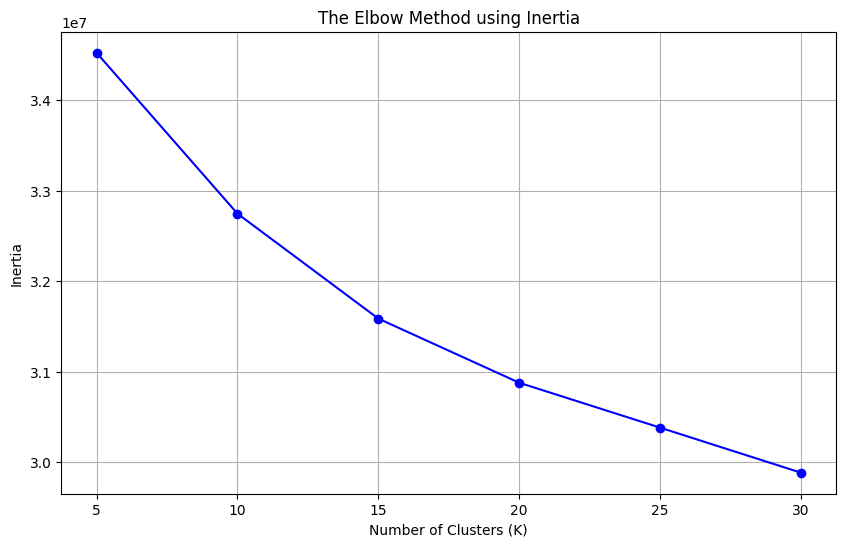

In [53]:
print("\n --- 최적의 K 찾기 (Elbow Method) ---")
inertias = []
k_range = range(5, 35, 5) # 5개부터 30개까지 5단위로 테스트

for k in k_range:
    # 학습
    model = KMeans(n_clusters=k, random_state=42, n_init='auto')
    model.fit(train_vectors)

    # 응집도(Inertia) 저장: 군집 내 데이터가 얼마나 뭉쳐있는지 수치
    inertias.append(model.inertia_)
    print(f" - K={k} 완료")

# 그래프 그리기
plt.figure(figsize=(10, 6))
plt.plot(k_range, inertias, 'bo-')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia')
plt.title('The Elbow Method using Inertia')
plt.grid(True)
plt.show()

In [33]:
# 엘보우 그래프가 꺾이지 않음
## 1. 텍스트 임베딩 데이터의 특성상 엘보우 포인트가 명확하지 않음
## 2. 기존의 6대 감정을 최소 2가지 이상의 구체적 상황으로 세분화하기 위해 K=12 선정